
### Model Training

In this module, I developed a framework for training multiple models easily with the intent of preventing overfitting. I first make a model pipeline that preprocesses data using standard scaling (b/c scikit learn models prefer normalized data). Then, I create a dictionary of model pipelines for organizational purposes. This would allow me to swap/add different models systematically. Next, I make hyperparameter grids for each model pipeline in order to again have a systematic way of swapping/adding different hyperparameters to tune. I then fit and tune models using 10 fold cross validation, with 20% of the observations used as a validation set. For this project I use 5 models: lasso, ridge, elastic-net, random forest classification, and a gradient boosted tree. 

Because this is a regression problem, I used r^2 and mean average error as my evaluation metrics. 

Random Forest gave the best mean average error and r^2. I used the best_estimator method to get the best model parameters for the random forest model. I then saved the model at a .pkl file.  

In [1]:
from __future__ import print_function  # Compatability with Python 3
print( 'Print function ready to serve.' )

Print function ready to serve.


In [9]:
# NumPy for numerical computing
import numpy as np

# Pandas for DataFrames
import pandas as pd
pd.set_option('display.max_columns', 100)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Matplotlib for visualization
from matplotlib import pyplot as plt
# display plots in the notebook
%matplotlib inline 

# Seaborn for easier visualization
import seaborn as sns

# Scikit-Learn for Modeling
import sklearn

In [10]:
# Import Elastic Net, Ridge Regression, and Lasso Regression
from sklearn.linear_model import ElasticNet, Ridge, Lasso

# Import Random Forest and Gradient Boosted Trees
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

In [11]:
# Load cleaned dataset from Module 3
df = pd.read_csv('analytical_base_table.csv')

print(df.shape)

(1864, 41)


<br id="split">
# 1. Split your dataset

I split the data to have 20% of observation as a validation set. 

In [12]:
# Function for splitting training and test set
from sklearn.model_selection import train_test_split

In [14]:
# Create separate object for target variable
y = df.tx_price
# Create separate object for input features
X = df.drop('tx_price', axis=1)

In [15]:
# Split X and y into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

In [16]:
print( len(X_train), len(X_test), len(y_train), len(y_test) )

1491 373 1491 373


<br id="pipelines">
# 2. Build model pipelines

I put my model pipelines in a dictionary for organizational purposes for when I fit and train the data using cross validation. 

In [17]:
# Summary statistics of X_train
X_train.describe()

,beds,baths,sqft,lot_size,basement,restaurants,groceries,nightlife,cafes,shopping,arts_entertainment,beauty_spas,active_life,median_age,married,college_grad,property_tax,insurance,median_school,num_schools,two_and_two,during_recession,property_age,school_score,exterior_walls_Brick,exterior_walls_Brick veneer,exterior_walls_Combination,exterior_walls_Metal,exterior_walls_Missing,exterior_walls_Other,exterior_walls_Siding (Alum/Vinyl),exterior_walls_Wood,roof_Asphalt,roof_Composition Shingle,roof_Missing,roof_Other,roof_Shake Shingle,roof_Wood Shake/ Shingles,property_type_Apartment / Condo / Townhouse,property_type_Single-Family
count,1491.000,1491.000,1491.000,1491.000,1491.000,1491.000,1491.000,1491.000,1491.000,1491.000,1491.000,1491.000,1491.000,1491.000,1491.000,1491.000,1491.000,1491.000,1491.000,1491.000,1491.000,1491.000,1491.000,1491.000,1491.000,1491.000,1491.000,1491.000,1491.000,1491.000,1491.000,1491.000,1491.000,1491.000,1491.000,1491.000,1491.000,1491.000,1491.000,1491.000
mean,3.434,2.578,2322.384,13245.311,0.882,39.461,4.469,4.944,5.190,39.904,3.360,23.173,15.801,38.633,69.322,65.298,464.195,139.714,6.485,2.801,0.093,0.265,24.513,18.027,0.372,0.028,0.058,0.059,0.120,0.038,0.258,0.067,0.074,0.626,0.189,0.062,0.031,0.018,0.422,0.578
std,1.073,0.932,1300.196,46397.868,0.323,46.138,4.465,8.282,7.334,52.093,4.662,25.757,17.606,6.665,19.924,16.965,229.263,72.195,1.997,0.496,0.290,0.441,21.223,6.470,0.483,0.166,0.234,0.236,0.325,0.190,0.438,0.250,0.261,0.484,0.392,0.242,0.173,0.133,0.494,0.494
min,1.000,1.000,500.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,22.000,11.000,5.000,88.000,30.000,1.000,1.000,0.000,0.000,0.000,3.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,3.000,2.000,1350.000,1563.500,1.000,7.000,1.000,0.000,0.000,6.000,0.000,4.000,4.000,33.000,58.000,54.000,321.000,94.000,5.000,3.000,0.000,0.000,6.000,12.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
50%,4.000,3.000,1910.000,6168.000,1.000,22.000,3.000,2.000,3.000,21.000,2.000,15.000,10.000,38.000,74.000,67.000,425.000,124.000,7.000,3.000,0.000,0.000,20.000,18.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,1.000
75%,4.000,3.000,3002.500,11761.000,1.000,57.500,7.000,6.000,6.000,50.500,5.000,35.000,21.000,43.000,84.000,79.000,569.000,168.500,8.000,3.000,0.000,1.000,39.000,24.000,1.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,1.000,1.000
max,5.000,6.000,7842.000,1220551.000,1.000,266.000,24.000,53.000,47.000,340.000,35.000,177.000,94.000,69.000,100.000,99.000,4508.000,1374.000,10.000,4.000,1.000,1.000,113.000,30.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000


In [18]:
# Standardize X_train. Didn't understand the concept of StandardScaler, so I practiced.
X_train_new = (X_train-X_train.mean())/(X_train.std())

In [19]:
# Summary statistics of X_train_new
X_train_new.describe()

,beds,baths,sqft,lot_size,basement,restaurants,groceries,nightlife,cafes,shopping,arts_entertainment,beauty_spas,active_life,median_age,married,college_grad,property_tax,insurance,median_school,num_schools,two_and_two,during_recession,property_age,school_score,exterior_walls_Brick,exterior_walls_Brick veneer,exterior_walls_Combination,exterior_walls_Metal,exterior_walls_Missing,exterior_walls_Other,exterior_walls_Siding (Alum/Vinyl),exterior_walls_Wood,roof_Asphalt,roof_Composition Shingle,roof_Missing,roof_Other,roof_Shake Shingle,roof_Wood Shake/ Shingles,property_type_Apartment / Condo / Townhouse,property_type_Single-Family
count,1491.000,1491.000,1491.000,1491.000,1491.000,1491.000,1491.000,1491.000,1491.000,1491.000,1491.000,1491.000,1491.000,1491.000,1491.000,1491.000,1491.000,1491.000,1491.000,1491.000,1491.000,1491.000,1491.000,1491.000,1491.000,1491.000,1491.000,1491.000,1491.000,1491.000,1491.000,1491.000,1491.000,1491.000,1491.000,1491.000,1491.000,1491.000,1491.000,1491.000
mean,-0.000,-0.000,0.000,-0.000,-0.000,-0.000,0.000,0.000,-0.000,0.000,-0.000,0.000,-0.000,0.000,-0.000,-0.000,-0.000,0.000,0.000,-0.000,0.000,0.000,-0.000,-0.000,-0.000,-0.000,0.000,0.000,-0.000,0.000,0.000,-0.000,0.000,0.000,-0.000,-0.000,0.000,-0.000,0.000,-0.000
std,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000
min,-2.269,-1.694,-1.402,-0.285,-2.733,-0.855,-1.001,-0.597,-0.708,-0.766,-0.721,-0.900,-0.897,-2.496,-2.927,-3.554,-1.641,-1.520,-2.747,-3.634,-0.319,-0.600,-1.155,-2.322,-0.769,-0.170,-0.249,-0.250,-0.369,-0.197,-0.590,-0.268,-0.282,-1.293,-0.483,-0.258,-0.178,-0.136,-0.854,-1.170
25%,-0.405,-0.620,-0.748,-0.252,0.366,-0.704,-0.777,-0.597,-0.708,-0.651,-0.721,-0.744,-0.670,-0.845,-0.568,-0.666,-0.625,-0.633,-0.744,0.402,-0.319,-0.600,-0.872,-0.932,-0.769,-0.170,-0.249,-0.250,-0.369,-0.197,-0.590,-0.268,-0.282,-1.293,-0.483,-0.258,-0.178,-0.136,-0.854,-1.170
50%,0.528,0.453,-0.317,-0.153,0.366,-0.378,-0.329,-0.355,-0.299,-0.363,-0.292,-0.317,-0.329,-0.095,0.235,0.100,-0.171,-0.218,0.258,0.402,-0.319,-0.600,-0.213,-0.004,-0.769,-0.170,-0.249,-0.250,-0.369,-0.197,-0.590,-0.268,-0.282,0.773,-0.483,-0.258,-0.178,-0.136,-0.854,0.854
75%,0.528,0.453,0.523,-0.032,0.366,0.391,0.567,0.128,0.110,0.203,0.352,0.459,0.295,0.655,0.737,0.808,0.457,0.399,0.758,0.402,-0.319,1.665,0.683,0.923,1.300,-0.170,-0.249,-0.250,-0.369,-0.197,1.694,-0.268,-0.282,0.773,-0.483,-0.258,-0.178,-0.136,1.170,0.854
max,1.460,3.672,4.245,26.021,0.366,4.910,4.374,5.802,5.701,5.761,6.786,5.972,4.442,4.556,1.540,1.987,17.638,17.097,1.760,2.420,3.130,1.665,4.169,1.850,1.300,5.872,4.016,3.992,2.706,5.060,1.694,3.728,3.542,0.773,2.070,3.876,5.603,7.361,1.170,0.854


In [20]:
# Function for creating model pipelines
from sklearn.pipeline import make_pipeline

In [21]:
# For standardization
from sklearn.preprocessing import StandardScaler

In [24]:
# Create pipelines dictionary
pipelines = {
    'lasso': make_pipeline(StandardScaler(), Lasso(random_state=123)),
    'ridge': make_pipeline(StandardScaler(), Ridge(random_state=123)),
    'enet': make_pipeline(StandardScaler(), ElasticNet(random_state=123))
}

In [56]:
# Add a pipeline for 'rf'
pipelines['rf'] = make_pipeline(StandardScaler(), RandomForestRegressor(random_state=123))
# Add a pipeline for 'gb'
pipelines['gb'] = make_pipeline(StandardScaler(), GradientBoostingRegressor(random_state=123))

In [57]:
# Check that we have all 5 algorithms, and that they are all pipelines
for key, value in pipelines.items():
    print( key, type(value) )

lasso <class 'sklearn.pipeline.Pipeline'>
ridge <class 'sklearn.pipeline.Pipeline'>
enet <class 'sklearn.pipeline.Pipeline'>
rf <class 'sklearn.pipeline.Pipeline'>
gb <class 'sklearn.pipeline.Pipeline'>


<br id="hyperparameters">
# 3. Declare hyperparameters to tune

I make a hyperparameter grid for each model I'd like to train. I then put these grids in a "hyperparameters" dictionary for organizational purposes. 

In [58]:
# List tuneable hyperparameters of our Lasso pipeline
pipelines['lasso'].get_params()

{'memory': None,
 'steps': [('standardscaler',
   StandardScaler(copy=True, with_mean=True, with_std=True)),
  ('lasso', Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=123,
      selection='cyclic', tol=0.0001, warm_start=False))],
 'standardscaler': StandardScaler(copy=True, with_mean=True, with_std=True),
 'lasso': Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
    normalize=False, positive=False, precompute=False, random_state=123,
    selection='cyclic', tol=0.0001, warm_start=False),
 'standardscaler__copy': True,
 'standardscaler__with_mean': True,
 'standardscaler__with_std': True,
 'lasso__alpha': 1.0,
 'lasso__copy_X': True,
 'lasso__fit_intercept': True,
 'lasso__max_iter': 1000,
 'lasso__normalize': False,
 'lasso__positive': False,
 'lasso__precompute': False,
 'lasso__random_state': 123,
 'lasso__selection': 'cyclic',
 'lasso__tol': 0.0001,
 'lasso__warm_start': False}

In [59]:
# Lasso hyperparameters
lasso_hyperparameters = {
    'lasso__alpha': [0.001,0.005,0.01,0.05,0.1,0.5,1,5,10]
}
# Ridge hyperparameters
ridge_hyperparameters={
    'ridge__alpha': [0.001,0.005,0.01,0.05,0.1,0.5,1,5,10]
}

In [60]:
# Elastic Net hyperparameters
enet_hyperparameters={
    'elasticnet__alpha': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10],
    'elasticnet__l1_ratio' : [0.1, 0.3, 0.5, 0.7, 0.9]  
}

In [61]:
# Random forest hyperparameters
rf_hyperparameters = {
    'randomforestregressor__n_estimators': [100, 200],
    'randomforestregressor__max_features': ['auto', 'sqrt', 0.33]
}

In [67]:
# Boosted tree hyperparameters
gb_hyperparameters = {
    'gradientboostingregressor__n_estimators':[100,200],
    'gradientboostingregressor__learning_rate':[0.05,0.2,0.2],
    'gradientboostingregressor__max_depth':[1,3,5]}

In [68]:
# Create hyperparameters dictionary
hyperparameters = {
    'lasso': lasso_hyperparameters,
    'ridge': ridge_hyperparameters,
    'enet': enet_hyperparameters,
    'rf': rf_hyperparameters,
    'gb': gb_hyperparameters
}

In [64]:
for key in ['enet', 'gb', 'ridge', 'rf', 'lasso']:
    if key in hyperparameters:
        if type(hyperparameters[key]) is dict:
            print( key, 'was found in hyperparameters, and it is a grid.' )
        else:
            print( key, 'was found in hyperparameters, but it is not a grid.' )
    else:
        print( key, 'was not found in hyperparameters')

enet was found in hyperparameters, and it is a grid.
gb was found in hyperparameters, and it is a grid.
ridge was found in hyperparameters, and it is a grid.
rf was found in hyperparameters, and it is a grid.
lasso was found in hyperparameters, and it is a grid.


<br id="fit-tune">
# 4. Fit and tune models with cross-validation

This is the part where the existence of hyperparameters and model pipelines dictionaries comes into play. By making these dictionaries, I can make a for loop that iterates through the pipelines dictionaries, and inputs the hyperparameter grid and model pipeline for each model into its associated GridSearchCV object. This results in an elegant way to cross validate many model pipelines. 

In [37]:
# Helper for cross-validation
from sklearn.model_selection import GridSearchCV

In [38]:
# Create cross-validation object from Lasso pipeline and Lasso hyperparameters
model = GridSearchCV(pipelines['lasso'], hyperparameters['lasso'], cv=10,n_jobs=-1)

In [65]:
# Fit and tune model
model.fit(X_train, y_train)

ValueError: Invalid parameter randomforestregressor for estimator Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('lasso', Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=123,
   selection='cyclic', tol=0.0001, warm_start=False))]). Check the list of available parameters with `estimator.get_params().keys()`.

In [42]:
pipelines.keys()

dict_keys(['lasso', 'ridge', 'enet', 'rf', 'gb'])

In [69]:
# Create empty dictionary called fitted_models
fitted_models = {}

# Loop through model pipelines, tuning each one and saving it to fitted_models
for name, pipeline in pipelines.items():
    # Create cross-validation object from pipeline and hyperparameters
    model = GridSearchCV(pipeline, hyperparameters[name], cv=10, n_jobs=-1)
    
    # Fit model on X_train, y_train
    model.fit(X_train, y_train)
    
    # Store model in fitted_models[name] 
    fitted_models[name] = model
    
    # Print '{name} has been fitted'
    print(name, 'has been fitted.')

c:\users\toshiba\appdata\local\programs\python\python36\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
c:\users\toshiba\appdata\local\programs\python\python36\lib\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
c:\users\toshiba\appdata\local\programs\python\python36\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


lasso has been fitted.


c:\users\toshiba\appdata\local\programs\python\python36\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
c:\users\toshiba\appdata\local\programs\python\python36\lib\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
c:\users\toshiba\appdata\local\programs\python\python36\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


ridge has been fitted.


c:\users\toshiba\appdata\local\programs\python\python36\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
c:\users\toshiba\appdata\local\programs\python\python36\lib\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
c:\users\toshiba\appdata\local\programs\python\python36\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


enet has been fitted.


c:\users\toshiba\appdata\local\programs\python\python36\lib\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
c:\users\toshiba\appdata\local\programs\python\python36\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


rf has been fitted.


c:\users\toshiba\appdata\local\programs\python\python36\lib\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
c:\users\toshiba\appdata\local\programs\python\python36\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


gb has been fitted.


In [70]:
# Check that we have 5 cross-validation objects
for key, value in fitted_models.items():
    print( key, type(value) )

lasso <class 'sklearn.model_selection._search.GridSearchCV'>
ridge <class 'sklearn.model_selection._search.GridSearchCV'>
enet <class 'sklearn.model_selection._search.GridSearchCV'>
rf <class 'sklearn.model_selection._search.GridSearchCV'>
gb <class 'sklearn.model_selection._search.GridSearchCV'>


In [71]:
from sklearn.exceptions import NotFittedError

for name, model in fitted_models.items():
    try:
        pred = model.predict(X_test)
        print(name, 'has been fitted.')
    except NotFittedError as e:
        print(repr(e))

lasso has been fitted.
ridge has been fitted.
enet has been fitted.
rf has been fitted.
gb has been fitted.


c:\users\toshiba\appdata\local\programs\python\python36\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
c:\users\toshiba\appdata\local\programs\python\python36\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
c:\users\toshiba\appdata\local\programs\python\python36\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
c:\users\toshiba\appdata\local\programs\python\python36\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
c:\users\toshiba\appdata\local\programs\pyth

<br id="evaluate">
# 5. Evaluate models and select winner

Metrics used: Mean average error and R^2. Wanted to find model with the lowest mean average error and the highest R^2. Picked that model as best. 

In [72]:
# Display best_score_ for each fitted model
for name, model in fitted_models.items():
    print(name, model.best_score_)

lasso 0.32073342671068134
ridge 0.3259795135456992
enet 0.3527117995451829
rf 0.5069561736890409
gb 0.5104830486073169


In [73]:
# Import r2_score and mean_absolute_error functions
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

In [74]:
# Display fitted random forest object
fitted_models['rf']

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('randomforestregressor', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
  ...rs='warn', n_jobs=None,
           oob_score=False, random_state=123, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'randomforestregressor__n_estimators': [100, 200], 'randomforestregressor__max_features': ['auto', 'sqrt', 0.33]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [75]:
# Predict test set using fitted random forest
pred = fitted_models['rf'].predict(X_test)

c:\users\toshiba\appdata\local\programs\python\python36\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


In [76]:
# Calculate and print R^2 and MAE
print('R^2: ', r2_score(y_test, pred))
print('MAE: ', mean_absolute_error(y_test, pred))

R^2:  0.4654409568626009
MAE:  79495.25798927614


In [77]:
# Code here
for name, model in fitted_models.items():
    pred = model.predict(X_test)
    print(name)
    print('R^2: ', r2_score(y_test, pred))
    print('MAE: ', mean_absolute_error(y_test, pred))

lasso
R^2:  0.35464010508409805
MAE:  93818.65569328083
ridge
R^2:  0.35634533435114657
MAE:  93716.244958099
enet
R^2:  0.35952039769324595
MAE:  94108.19906453215
rf
R^2:  0.4654409568626009
MAE:  79495.25798927614
gb
R^2:  0.4575713364248166
MAE:  78712.51869564646


c:\users\toshiba\appdata\local\programs\python\python36\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
c:\users\toshiba\appdata\local\programs\python\python36\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
c:\users\toshiba\appdata\local\programs\python\python36\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
c:\users\toshiba\appdata\local\programs\python\python36\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
c:\users\toshiba\appdata\local\programs\pyth

c:\users\toshiba\appdata\local\programs\python\python36\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


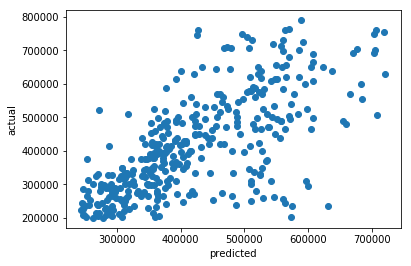

In [78]:
gb_pred = fitted_models['rf'].predict(X_test)
plt.scatter(gb_pred, y_test)
plt.xlabel('predicted')
plt.ylabel('actual')
plt.show()

In [79]:
type(fitted_models['rf'])

sklearn.model_selection._search.GridSearchCV

In [80]:
type(fitted_models['rf'].best_estimator_)

sklearn.pipeline.Pipeline

In [81]:
fitted_models['rf'].best_estimator_

Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('randomforestregressor', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=None,
           oob_score=False, random_state=123, verbose=0, warm_start=False))])

 winning values for hyperparameters are:
* <code style="color:steelblue">n_estimators: <span style="color:crimson">200</span></code>
* <code style="color:steelblue">max_features : <span style="color:crimson">'auto'</span></code>



In [82]:
import pickle

In [83]:
with open('final_model.pkl', 'wb') as f:
    pickle.dump(fitted_models['rf'].best_estimator_, f)